## Welcome to the `deeplabv3+` Workshop!
In this workshop, we'll learn the concept of how to use deeplabv3+ model (involving Atrous convolutions, Atrous Spatial Pyramid Pooling, Decoder) for Semantic Segmentation using Pytorch. We'll do the following tasks:

- Dataset : Download and use BDD100k dataset
- Network : Define deeplabv3+ model using resnet50, Atrous convolutions, ASPP modules, Decoder
- Training : Train and validate model on the custom dataset
- Evaluate : Evaluate the model on Test Data and visualize results

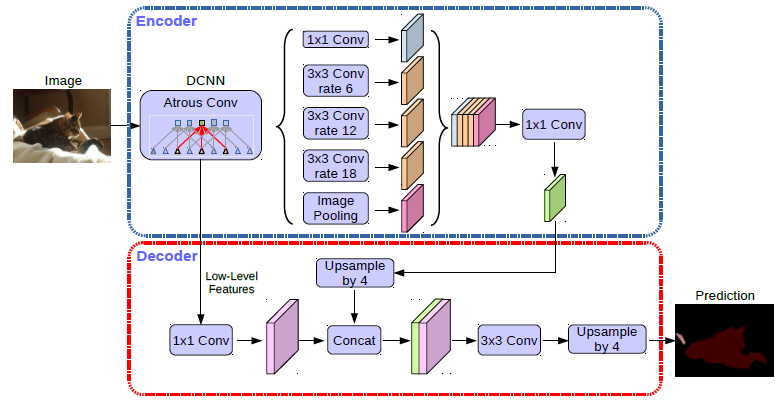

[Image reference](https://arxiv.org/pdf/1802.02611.pdf)

In [ ]:
try:
    import segmentation_models_pytorch as smp
except:
    !pip install segmentation-models-pytorch
    import segmentation_models_pytorch as smp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 7.0 MB/s 
     |████████████████████████████████| 376 kB 61.6 MB/s 
     |████████████████████████████████| 58 kB 8.0 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=148cd539f791d1953655658d3ae0a3918656f2f6d20aeeff5c507cd7123ed9fa
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=a00c7fb2cfb2475f236029856ee26fa1a6f7f058c86ef10d99bdd56111ef6dab
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


# Basic Imports

In [ ]:
# basic imports
import numpy as np

# DL library imports
import torch
import torch.nn as nn
import torch.nn.functional as F

# libraries for loading image, plotting 
import cv2
import matplotlib.pyplot as plt

# 1. Dataset : Download and use BDD100k dataset

In [ ]:
ENVIRONMENT = 'colab'

if ENVIRONMENT == 'kaggle':
    dataset_path = '../input/image-segmentation'
    output_path = '.'
    
elif ENVIRONMENT == 'colab':
    import os
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    os.chdir("/content/drive/My Drive/thinkAutonomous/image_segmentation/finalContent")
    dataset_path = 'dataset'
    output_path = 'dataset'
    
else:
    raise NotImplementedError("Env can be kaggle or colab")

Mounted at /content/drive


In [ ]:
targetWidth = 320
targetHeight = 180
# dataset_path = 'dataset'
images = np.load(f'{dataset_path}/image_{targetHeight}_{targetWidth}.npy')
labels = np.load(f'{dataset_path}/label_{targetHeight}_{targetWidth}.npy')
print(f"RGB images shape = {images.shape}, Label images shape = {labels.shape}")

RGB images shape = (3430, 180, 320, 3), Label images shape = (3430, 180, 320)


In [ ]:
# utility functions to get BDD100k Pytorch dataset and dataloaders
from utils import get_datasets, get_dataloaders

train_set, val_set, test_set= get_datasets(images, labels)
sample_image, sample_label = train_set[0]
print(f"There are {len(train_set)} train images, {len(val_set)} validation images, {len(test_set)} test Images")
print(f"Input shape = {sample_image.shape}, output label shape = {sample_label.shape}")

train_dataloader, val_dataloader, test_dataloader = get_dataloaders(train_set, val_set, test_set)

There are 2401 train images, 686 validation images, 343 test Images
Input shape = torch.Size([3, 180, 320]), output label shape = torch.Size([180, 320])


## Show Sample images from dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


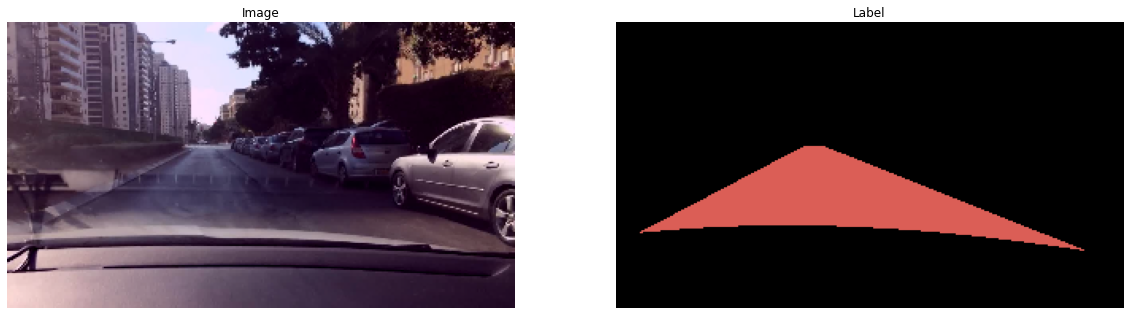

In [ ]:
from utils import inverse_transform, train_id_to_color

rgb_image, label = train_set[np.random.choice(len(train_set))]
rgb_image = inverse_transform(rgb_image).permute(1, 2, 0).cpu().detach().numpy()
label = label.cpu().detach().numpy()

# plot sample image
fig, axes = plt.subplots(1,2, figsize=(20,10))
axes[0].imshow(rgb_image);
axes[0].set_title("Image");
axes[0].axis('off');
axes[1].imshow(train_id_to_color[label]);
axes[1].set_title("Label");
axes[1].axis('off');

# Network : Define deeplabv3+ model using resnet50, Atrous convolutions, ASPP modules, Decoder

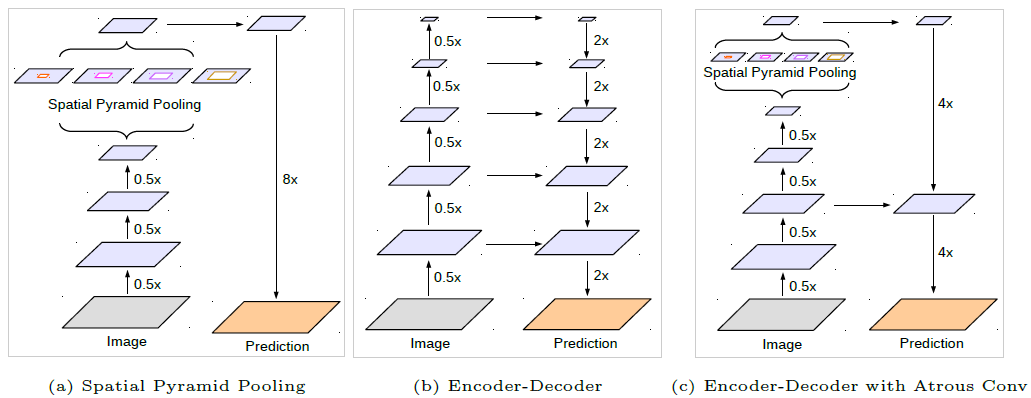

[Image reference](https://arxiv.org/pdf/1802.02611)

In [ ]:
class aspp_conv(nn.Module):
    def __init__(self, in_channels, out_channels, dilation_rate):
        super(aspp_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, dilation=dilation_rate, padding=dilation_rate, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU())
        
    def forward(self, x):
        return self.conv(x)

In [ ]:
class aspp_pool(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(aspp_pool, self).__init__()
        self.pooling_module = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU())
        
    def forward(self, x):
        input_size = x.shape[-2:]
        x = self.pooling_module(x)
        return F.interpolate(x, size=input_size, mode='bilinear', align_corners=False)

In [ ]:
class atrous_spatial_pyramid_pooling(nn.Module):
    def __init__(self, in_channels, out_channels, dilation_rates):
        super(atrous_spatial_pyramid_pooling, self).__init__()

        layers = nn.ModuleList([])
        
        # skip-connection, match the output channels
        # using 1x1 convolutions
        layers.append(nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        ))
        
        # spatial pyramid pooling wiht atrous convolutions
        for rate in dilation_rates:
            layers.append(aspp_conv(in_channels, out_channels, rate))
            
        # image pooling layer
        layers.append(aspp_pool(in_channels, out_channels))
        
        # create Pytorch module list
        self.layers = nn.ModuleList(layers)
        
        # 1x1 convolution to project concatenated output
        # to desired number of channels
        self.project = nn.Sequential(
            nn.Conv2d(len(layers) * out_channels, out_channels, kernel_size=1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
    
    def forward(self, x):
        conv_outputs = []
        for mod in self.layers:
            mod_output = mod(x)
            conv_outputs.append(mod_output)
        
        # concatenate output and reduce num_channels
        output = self.project(torch.cat(conv_outputs, dim=1))
        return output

In [ ]:
class deeplabv3_decoder(nn.Module):
    def __init__(self, num_classes):
        super(deeplabv3_decoder, self).__init__()
        self.num_classes = num_classes
        
        # resnet low level features contain 256 channels
        self.low_level_project = nn.Sequential(
            nn.Conv2d(256, 48, kernel_size=1, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU())
        
        # classifier head
        self.cls = nn.Sequential(
            nn.Conv2d(304, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256), nn.ReLU(),            
            nn.Conv2d(256, self.num_classes, kernel_size=1))
                     
        
    def forward(self, x, low_level_feat):
        # projected_low_level_feat = (48, h//4, w//4)
        low_level_feat = self.low_level_project(low_level_feat)

        # x = (256, h//4, w//4)
        x = F.interpolate(x, size=low_level_feat.size()[2:], mode='bilinear', align_corners=False)
        
        # x = (256 + 48, h//4, w//4)
        x = torch.cat((x, low_level_feat), dim=1)
        
        # x = (num_classes, h//4, w//4)
        x = self.cls(x)
        return x

In [ ]:
from torchvision.models import resnet50

class deeplabv3_plus(nn.Module):
    def __init__(self, in_channels, output_stride, num_classes):
        super(deeplabv3_plus, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.output_stride = output_stride
        
        if(output_stride == 16):
            dilation_rates = [6, 12, 18]
            replace_stride_with_dilation = [False, False, True]
            
        elif(output_stride == 8):
            dilation_rates = [12, 24, 36]
            replace_stride_with_dilation=[False, True, True]
                
        # backbone layers    
        backbone = resnet50(pretrained=True, replace_stride_with_dilation = replace_stride_with_dilation)        
        self.initial = nn.Sequential(*list(backbone.children())[:4])
        self.layer1 = backbone.layer1
        self.layer2 = backbone.layer2
        self.layer3 = backbone.layer3
        self.layer4 = backbone.layer4
        
        # ASPP modules
        aspp_out_channels = 256
        aspp_in_channels = int(backbone.fc.in_features)        
        self.aspp_module = atrous_spatial_pyramid_pooling(aspp_in_channels, 
                       out_channels=aspp_out_channels, dilation_rates=dilation_rates)
        
        # Decoder module
        self.decoder = deeplabv3_decoder(self.num_classes)
                      
    def forward(self, x):
        input_size = x.shape[-2:]
        
        # Pass input through Backbone layers
        x = self.initial(x)
        low_level_feat = self.layer1(x)
        x = self.layer2(low_level_feat)
        x = self.layer3(x)
        x = self.layer4(x)
                        
        # ASPP and classifier layers
        aspp_output = self.aspp_module(x)
        decoder_output = self.decoder(aspp_output, low_level_feat)
        return F.interpolate(decoder_output, size=input_size, mode='bilinear', align_corners=False)

# 3. Training : Train and validate model on the custom dataset


We will reuse the utility functions we defined in FCN notebook

In [ ]:
from utils import meanIoU                  # metric class
from utils import plot_training_results    # function to plot training curves
from utils import evaluate_model           # evaluation function
from utils import train_validate_model     # train validate function

## Model Training

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Starting 1 epoch ...


100%|██████████| 86/86 [00:25<00:00,  3.39it/s]


Epoch: 1, trainLoss:0.51898, validationLoss:0.41707, meanIoU: 0.62
Starting 2 epoch ...


100%|██████████| 86/86 [00:25<00:00,  3.33it/s]


Epoch: 2, trainLoss:0.26910, validationLoss:0.36281, meanIoU: 0.69
Starting 3 epoch ...


100%|██████████| 86/86 [00:25<00:00,  3.35it/s]


Epoch: 3, trainLoss:0.18300, validationLoss:0.24518, meanIoU: 0.73


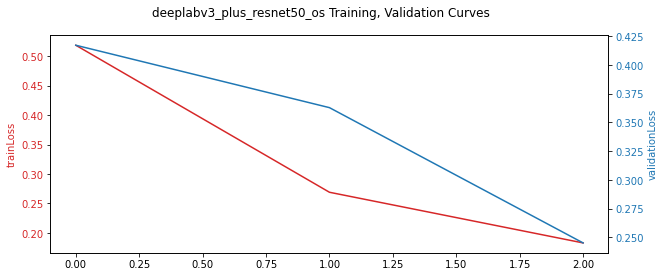

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

# MODEL HYPERPARAMETERS
N_EPOCHS = 3
NUM_CLASSES = 3
MAX_LR = 3e-4
MODEL_NAME = 'deeplabv3_plus_resnet50_os'

import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
criterion = smp.losses.DiceLoss('multiclass', classes=[0,1,2], log_loss = True, smooth=1.0)

# create model, optimizer, lr_scheduler and pass to training function
model = deeplabv3_plus(in_channels=3, output_stride=8, num_classes=NUM_CLASSES).to(device)
optimizer = optim.Adam(model.parameters(), lr=MAX_LR)
scheduler = OneCycleLR(optimizer, max_lr= MAX_LR, epochs = N_EPOCHS,steps_per_epoch = len(train_dataloader), 
                       pct_start=0.3, div_factor=10, anneal_strategy='cos')

_ = train_validate_model(model, N_EPOCHS, MODEL_NAME, criterion, optimizer, 
                         device, train_dataloader, val_dataloader, meanIoU, 'meanIoU',
                         NUM_CLASSES, lr_scheduler = scheduler, output_path = output_path)

# 4. Evaluate : Evaluate the model on Test Data and visualize results 

In [ ]:
model.load_state_dict(torch.load(f'{output_path}/{MODEL_NAME}.pt', map_location=device))
_, test_metric = evaluate_model(model, test_dataloader, criterion, meanIoU, NUM_CLASSES, device)
print(f"\nModel has {test_metric} mean IoU in test set")

100%|██████████| 43/43 [00:12<00:00,  3.32it/s]


Model has 0.7407766844113017 mean IoU in test set


In [ ]:
from utils import visualize_predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


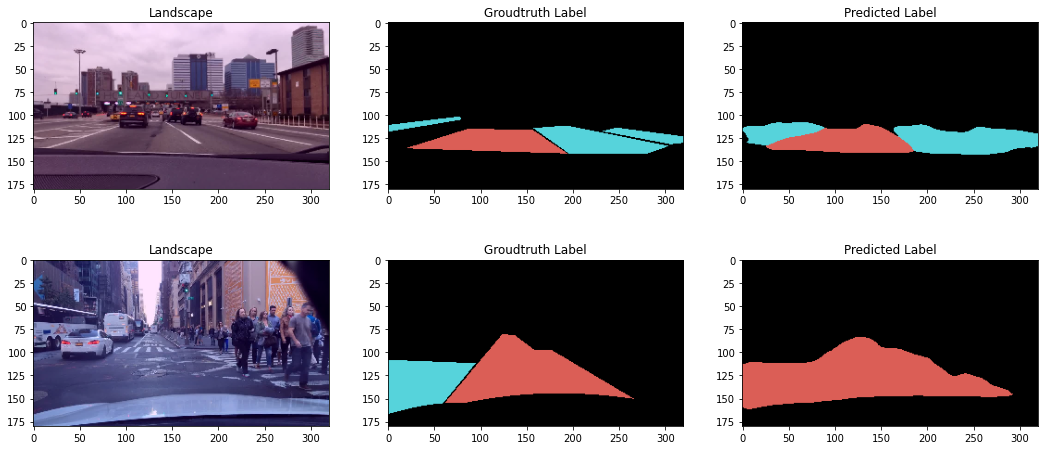

In [ ]:
num_test_samples = 2
_, axes = plt.subplots(num_test_samples, 3, figsize=(3*6, num_test_samples * 4))
visualize_predictions(model, test_set, axes, device, numTestSamples=num_test_samples)

## Test on sample video

In [1]:
from IPython.display import HTML
HTML("""
    <video alt="test" controls>
        <source src="videos/costa_rica_challenge_360_640_deeplabv3_plus_resnet50_os_output.avi" type="video/mp4">
    </video>
""")